In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from recbole.config import Config
from recbole.data import create_dataset, data_preparation

from logging import getLogger
from recbole.model.general_recommender import BPR, Pop
from recbole.model.sequential_recommender import Caser
from recbole.trainer import Trainer
from recbole.utils import init_seed, init_logger

import torch
from recbole.data.interaction import Interaction

import pickle
import os

import make_atomic_files as at

In [2]:
def get_history(inter):
    visits = []
    set_uid = set(inter['uid:token'])
    for u in set_uid:
        visits.append(inter[inter['uid:token'] == u]['venue_id:token'].values.tolist())
    
    return np.array(visits)

inter = pd.read_csv('foursquare/foursquare.inter', sep='\t')

visits = get_history(inter)

## Tuning

In [8]:
from recbole.trainer import HyperTuning
from recbole.utils import init_seed
import os
from recbole.utils import get_model, get_trainer

In [3]:
def tuning():
    def objective_function(config_dict=None, config_file_list=None):
        k = 10

        config_dict = {
            'model': 'BPR',
            'data_path': os.getcwd(),
            'seed': 1234,
            'reproducibility': False,
            'topk': 10,
            'use_gpu': True

        }

        config = Config(config_dict=config_dict, config_file_list=['foursquare_general.yaml'])
        init_seed(config['seed'], config['reproducibility'])
        dataset = create_dataset(config)
        train_data, valid_data, test_data = data_preparation(config, dataset)
        model_name = config['model']
        model = get_model(model_name)(config, train_data._dataset).to(config['device'])
        trainer = get_trainer(config['MODEL_TYPE'], config['model'])(config, model)
        best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)
        test_result = trainer.evaluate(test_data)

        return {
            'model': model_name,
            'best_valid_score': best_valid_score,
            'valid_score_bigger': config['valid_metric_bigger'],
            'best_valid_result': best_valid_result,
            'test_result': test_result
        }

    hp = HyperTuning(objective_function=objective_function, algo='random', early_stop=10,
                    max_evals=100, params_file='bpr.hyper', fixed_config_file_list=['foursquare_general.yaml'])

    hp.run()
    params = hp.best_params
    return params

## Train General Recommendation

In [22]:
params = {'dynamic': False, 'embedding_size': 128, 'learning_rate': 0.07885866707608949, 'mlp_hidden_size': '[64,64,64]', 'sample_num': 5, 'train_batch_size': 4096}

In [4]:
def training(params):

    config_dict = {
            'model': 'BPR',
            'data_path': os.getcwd(),
            'seed': 1234,
            'reproducibility': False,
            'topk': 10,
            'use_gpu': True
    }
    # configurations initialization
    k = 10

    config = Config(model='BPR', dataset='foursquare', config_file_list=['foursquare_general.yaml'], config_dict = config_dict | params)

    # init random seed
    init_seed(config['seed'], config['reproducibility'])

    # dataset creating and filtering
    dataset = create_dataset(config)

    # dataset splitting
    train_data, valid_data, test_data = data_preparation(config, dataset)

    model = BPR(config, train_data.dataset).to(config['device'])

    # trainer loading and initialization
    trainer = Trainer(config, model)

    # model training
    best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)

    # model evaluation
    test_result = trainer.evaluate(test_data)
    print(test_result)

    return model, test_result

## Make prediction

In [12]:
def make_predict(model):
    k = 10
    inter = pd.read_csv('foursquare/foursquare.inter', sep='\t')
    visits = get_history(inter)

    unique_users = list(set(inter['uid:token']))


    #make prediction for users
    input_inter = Interaction({
        'uid': torch.tensor(unique_users),
        'venue_id': torch.tensor(visits)
    })

    with torch.no_grad():
        scores = model.full_sort_predict(input_inter).reshape((len(unique_users), -1))

    #length |items| + 1 because of the padding
    print(scores.shape)

    # get the 10 items with highest scores
    rec_list = np.argsort(scores, axis = 1)[:, -k:]

    # select one item at random for each user
    def random_choice(a):
        # select one item, but then translated back
        r_c = np.random.choice(a, 1)
        return int(r_c) - 1

    random_item = np.apply_along_axis(random_choice, 1, rec_list)
    return random_item

## Add new values in the dataset

In [13]:
def update_interactions(users, items):
    inter = pd.read_csv('foursquare/foursquare.inter', sep='\t')
    current_time = max(inter['timestamp:token'])+1
    new_locations = pd.DataFrame({'uid:token': users, 'venue_id:token':items.tolist(), 'timestamp:token':[current_time]*len(items)}, columns=['uid:token', 'venue_id:token', 'timestamp:token'])
    new_locations.head()

    inter = pd.concat([inter, new_locations], axis = 0).reset_index(drop = True)
    inter.sort_values(by=['uid:token', 'timestamp:token'], inplace=True)

    inter.to_csv('foursquare/foursquare.inter', index=False, sep = '\t')

## Feedback Loop

In [14]:
at.og_atomic_files()

hit = []
pres = []
card = []

inter = pd.read_csv('foursquare/foursquare.inter', sep='\t')
unique_users = list(set(inter['uid:token']))
unique_locations = list(set(inter['venue_id:token']))

m = 5
params = tuning()

for e in range(30):

    if e % m == 0:
        model, results = training(params)
        hit.append(results['hit@10'])
        pres.append(results['precision@10'])

    predictions = make_predict(model)
    update_interactions(unique_users, predictions)

    card.append(len(set(predictions)))

    print(results)
    print(len(set(predictions)))

running parameters:                                    
{'dynamic': False, 'embedding_size': 96, 'learning_rate': 0.049822529215994345, 'mlp_hidden_size': '[128,128]', 'sample_num': 1, 'train_batch_size': 2048}
current best valid score: 0.4663                       
current best valid result:                             
OrderedDict([('hit@10', 0.4663), ('precision@10', 0.0466)])
current test result:                                   
OrderedDict([('hit@10', 0.4201), ('precision@10', 0.042)])
running parameters:                                                   
{'dynamic': True, 'embedding_size': 96, 'learning_rate': 0.0068317495351137595, 'mlp_hidden_size': '[64,64,64]', 'sample_num': 5, 'train_batch_size': 4096}
running parameters:                                                   
{'dynamic': False, 'embedding_size': 64, 'learning_rate': 0.0916746791436222, 'mlp_hidden_size': '[128,128]', 'sample_num': 5, 'train_batch_size': 2048}
running parameters:                                

/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.4229), ('precision@10', 0.0423)])
996
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.4229), ('precision@10', 0.0423)])
1003
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.4229), ('precision@10', 0.0423)])
993
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.4229), ('precision@10', 0.0423)])
998
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.4229), ('precision@10', 0.0423)])
1001
OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
997
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
1007
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
1003
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
1003
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
995
OrderedDict([('hit@10', 0.0933), ('precision@10', 0.0093)])
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.0933), ('precision@10', 0.0093)])
1013
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.0933), ('precision@10', 0.0093)])
1007
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.0933), ('precision@10', 0.0093)])
993
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.0933), ('precision@10', 0.0093)])
998
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.0933), ('precision@10', 0.0093)])
996
OrderedDict([('hit@10', 0.1016), ('precision@10', 0.0102)])
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1016), ('precision@10', 0.0102)])
1007
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1016), ('precision@10', 0.0102)])
1016
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1016), ('precision@10', 0.0102)])
1025
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1016), ('precision@10', 0.0102)])
1022
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1016), ('precision@10', 0.0102)])
1014
OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
1018
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
1004
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
1014
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
1004
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.1034), ('precision@10', 0.0103)])
1015
OrderedDict([('hit@10', 0.0868), ('precision@10', 0.0087)])
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.0868), ('precision@10', 0.0087)])
1018
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.0868), ('precision@10', 0.0087)])
1014
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.0868), ('precision@10', 0.0087)])
1016
torch.Size([1083, 27899])


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


OrderedDict([('hit@10', 0.0868), ('precision@10', 0.0087)])
1020
torch.Size([1083, 27899])
OrderedDict([('hit@10', 0.0868), ('precision@10', 0.0087)])
1014


/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/ipykernel_3552/2199853656.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(r_c) - 1


In [1]:
hit, pres, card = ([0.4894, 0.0674, 0.0905, 0.1404, 0.0637, 0.1145],
 [0.0489, 0.0067, 0.009, 0.014, 0.0064, 0.0114],
 [877,
  885,
  857,
  890,
  894,
  1001,
  1010,
  990,
  1011,
  1022,
  921,
  939,
  927,
  926,
  935,
  890,
  901,
  890,
  894,
  894,
  831,
  824,
  834,
  813,
  828,
  1043,
  1042,
  1047,
  1028,
  1029])

In [15]:
import matplotlib.pyplot as plt

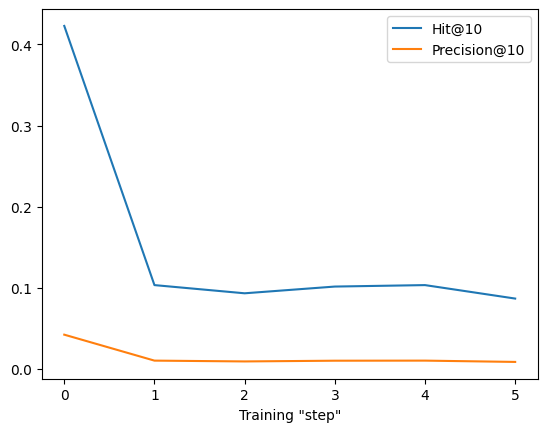

In [16]:
plt.plot(range(len(hit)), hit)
plt.plot(range(len(hit)), pres)
plt.legend(['Hit@10', 'Precision@10'])
plt.xlabel('Training "step"')
plt.show()

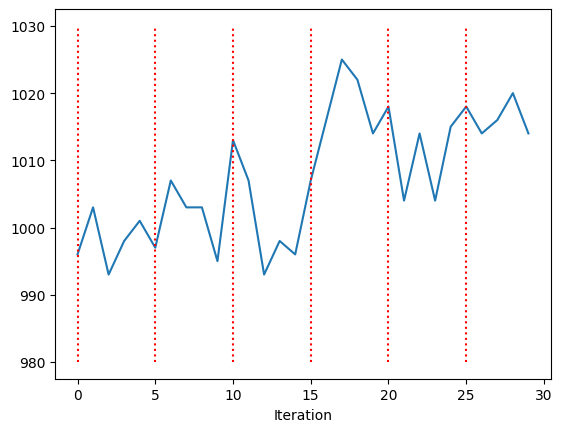

In [21]:
plt.plot(range(len(card)), card)
plt.vlines(range(0,30,5),980, 1030, 'red', 'dotted')
plt.xlabel('Iteration')
plt.show()